**UNGGAH DATASET DARI GDRIVE**

In [1]:
!gdown 1X3DtXwL8y3mskIlzpSYuOE6sQL91jx6L

Downloading...
From (original): https://drive.google.com/uc?id=1X3DtXwL8y3mskIlzpSYuOE6sQL91jx6L
From (redirected): https://drive.google.com/uc?id=1X3DtXwL8y3mskIlzpSYuOE6sQL91jx6L&confirm=t&uuid=a8faef4f-e59b-4173-a68d-ba7018390494
To: /content/KlasifikasiUTS.csv
100% 151M/151M [00:01<00:00, 115MB/s]


**LIBRARY**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, accuracy_score,
    precision_score, recall_score, f1_score
)

import tensorflow as tf
from tensorflow.keras import layers, callbacks

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

**DATA LOADING & CLEANING**

In [3]:
df = pd.read_csv("/content/KlasifikasiUTS.csv")

target = df.select_dtypes(include='int').columns[0]
y_raw = df[target]
X_raw = df.drop(columns=[target])

X_raw.dropna(axis=1, how='all', inplace=True)
X_raw.fillna(method='ffill', inplace=True)

<ipython-input-3-1419055196>:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_raw.fillna(method='ffill', inplace=True)


**MENGHITUNG KORELASI MATRIKS DAN VISUALISASI HEATMAP**

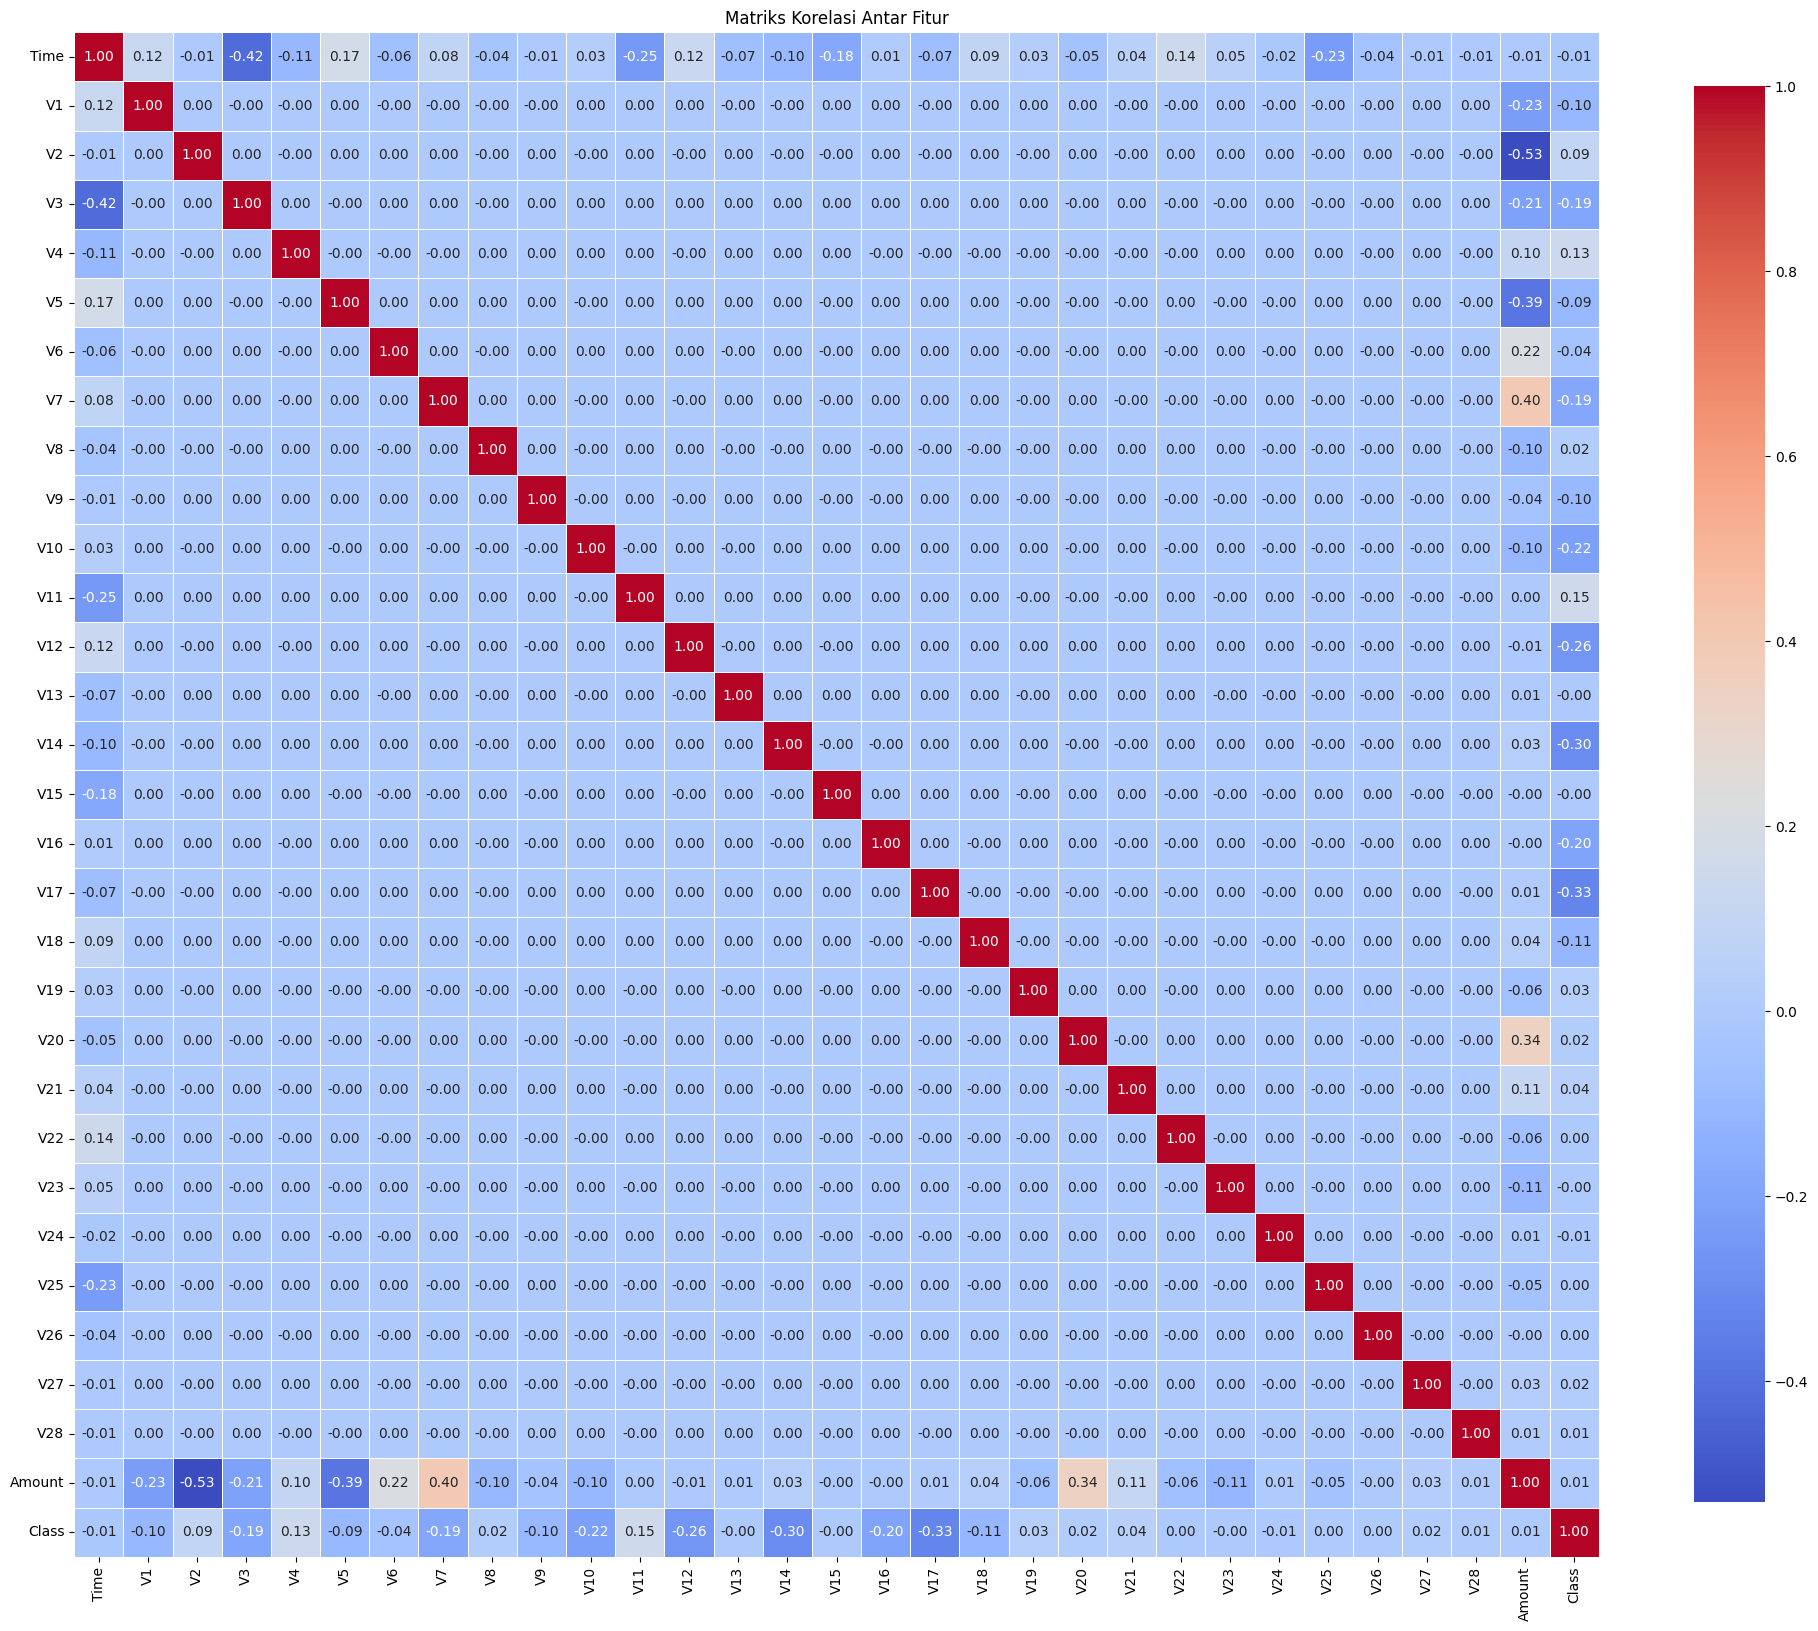

In [14]:
corr_matrix = df.corr()

plt.figure(figsize=(20, 18))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Matriks Korelasi Antar Fitur")
plt.tight_layout()
plt.show()

**FEATURE & TARGET PROCESSING**

In [4]:
num_cols = X_raw.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_raw.select_dtypes(include=['object', 'category']).columns.tolist()

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

X_ready = preprocessor.fit_transform(X_raw)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y_raw.values.reshape(-1, 1)).flatten()

X_tr, X_te, y_tr, y_te = train_test_split(X_ready, y_scaled, test_size=0.2, random_state=42)

**MODEL TENSORFLOW**

In [5]:
tf_model = tf.keras.Sequential([
    layers.Input(shape=(X_tr.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall', 'AUC']
)

early_cb = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tf_model.fit(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=100,
    batch_size=32,
    callbacks=[early_cb],
    verbose=1
)

Epoch 1/100
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - AUC: 0.8921 - Precision: 0.1041 - Recall: 0.6140 - accuracy: 0.9739 - loss: 0.0779 - val_AUC: 0.9385 - val_Precision: 0.7900 - val_Recall: 0.8061 - val_accuracy: 0.9993 - val_loss: 0.0117
Epoch 2/100
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - AUC: 0.9159 - Precision: 0.8354 - Recall: 0.7034 - accuracy: 0.9993 - loss: 0.0039 - val_AUC: 0.9284 - val_Precision: 0.8041 - val_Recall: 0.7959 - val_accuracy: 0.9993 - val_loss: 0.0087
Epoch 3/100
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - AUC: 0.9367 - Precision: 0.8453 - Recall: 0.7461 - accuracy: 0.9993 - loss: 0.0034 - val_AUC: 0.9435 - val_Precision: 0.8041 - val_Recall: 0.7959 - val_accuracy: 0.9993 - val_loss: 0.0109
Epoch 4/100
7121/7121 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - AUC: 0.9437 - Precision: 0.8414 - Recall: 0.7358 - accuracy: 0.9993 - loss: 0.0034 - val_AUC: 0.9385 - val_Precision: 0.8061 - val_Recall: 0.8061 - val_accuracy: 0.9993 - val_loss: 0.0123
Epoch 5/100
7121

**EVALUASI HASIL DARI TENSORFLOW**

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
=== TensorFlow Classification Report ===
              precision    recall  f1-score   support

         0.0     0.9997    0.9998    0.9997     56864
         1.0     0.8696    0.8163    0.8421        98

    accuracy                         0.9995     56962
   macro avg     0.9346    0.9081    0.9209     56962
weighted avg     0.9995    0.9995    0.9995     56962



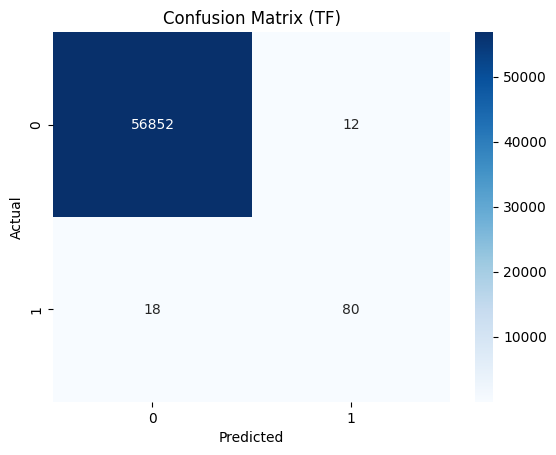

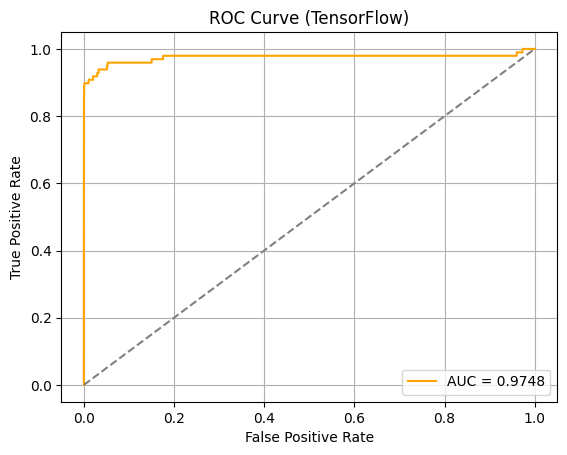

In [6]:
y_prob_tf = tf_model.predict(X_te).flatten()
y_label_tf = (y_prob_tf > 0.5).astype(int)

print("=== TensorFlow Classification Report ===")
print(classification_report(y_te, y_label_tf, digits=4))

cm_tf = confusion_matrix(y_te, y_label_tf)
sns.heatmap(cm_tf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (TF)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr_tf, tpr_tf, _ = roc_curve(y_te, y_prob_tf)
auc_tf = auc(fpr_tf, tpr_tf)

plt.plot(fpr_tf, tpr_tf, label=f"AUC = {auc_tf:.4f}", color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve (TensorFlow)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

**SETUP PYTORCH**

In [8]:
X_tr_torch = torch.tensor(X_tr, dtype=torch.float32)
X_te_torch = torch.tensor(X_te, dtype=torch.float32)

y_tr_torch = torch.tensor(y_tr, dtype=torch.float32).unsqueeze(1)
y_te_torch = torch.tensor(y_te, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_tr_torch, y_tr_torch)
test_ds = TensorDataset(X_te_torch, y_te_torch)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)

**MODEL PYTORCH**

In [9]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

pt_model = BinaryClassifier(X_tr_torch.shape[1])
loss_fn = nn.BCELoss()
optim = torch.optim.Adam(pt_model.parameters(), lr=0.001)

**TRAINING PYTORCH**

In [10]:
def train_pytorch_model(model, loader, loss_fn, optim, n_epochs=50):
    model.train()
    for ep in range(n_epochs):
        total_loss = 0
        for xb, yb in loader:
            optim.zero_grad()
            preds = model(xb)
            loss = loss_fn(preds, yb)
            loss.backward()
            optim.step()
            total_loss += loss.item()
        print(f"Epoch {ep+1}, Loss: {total_loss/len(loader):.4f}")

train_pytorch_model(pt_model, train_dl, loss_fn, optim)

Epoch 1, Loss: 0.0197
Epoch 2, Loss: 0.0034
Epoch 3, Loss: 0.0032
Epoch 4, Loss: 0.0031
Epoch 5, Loss: 0.0028
Epoch 6, Loss: 0.0028
Epoch 7, Loss: 0.0027
Epoch 8, Loss: 0.0026
Epoch 9, Loss: 0.0026
Epoch 10, Loss: 0.0024
Epoch 11, Loss: 0.0024
Epoch 12, Loss: 0.0023
Epoch 13, Loss: 0.0024
Epoch 14, Loss: 0.0022
Epoch 15, Loss: 0.0023
Epoch 16, Loss: 0.0023
Epoch 17, Loss: 0.0022
Epoch 18, Loss: 0.0020
Epoch 19, Loss: 0.0023
Epoch 20, Loss: 0.0024
Epoch 21, Loss: 0.0020
Epoch 22, Loss: 0.0020
Epoch 23, Loss: 0.0020
Epoch 24, Loss: 0.0021
Epoch 25, Loss: 0.0019
Epoch 26, Loss: 0.0020
Epoch 27, Loss: 0.0019
Epoch 28, Loss: 0.0020
Epoch 29, Loss: 0.0020
Epoch 30, Loss: 0.0019
Epoch 31, Loss: 0.0018
Epoch 32, Loss: 0.0019
Epoch 33, Loss: 0.0019
Epoch 34, Loss: 0.0019
Epoch 35, Loss: 0.0017
Epoch 36, Loss: 0.0019
Epoch 37, Loss: 0.0019
Epoch 38, Loss: 0.0018
Epoch 39, Loss: 0.0018
Epoch 40, Loss: 0.0018
Epoch 41, Loss: 0.0017
Epoch 42, Loss: 0.0015
Epoch 43, Loss: 0.0017
Epoch 44, Loss: 0.00

**EVALUASI HASIL DARI PYTORCH**

=== PyTorch Classification Report ===
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8404    0.8061    0.8229        98

    accuracy                         0.9994     56962
   macro avg     0.9200    0.9029    0.9113     56962
weighted avg     0.9994    0.9994    0.9994     56962



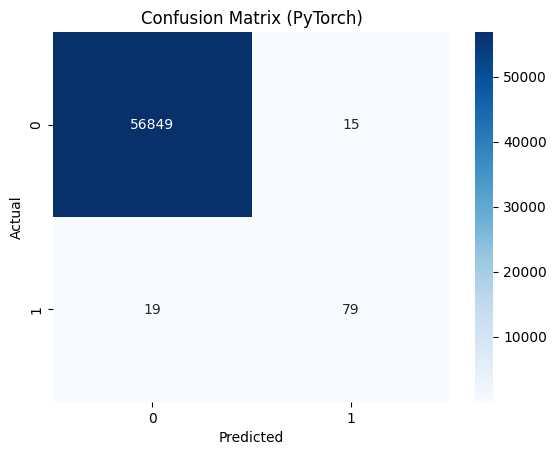

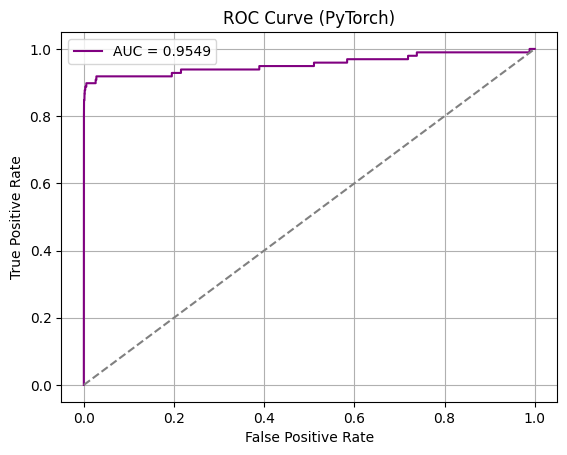

In [11]:
pt_model.eval()
with torch.no_grad():
    pred_probs = pt_model(X_te_torch).squeeze().numpy()
    pred_labels = (pred_probs >= 0.5).astype(int)
    true_labels = y_te_torch.squeeze().numpy().astype(int)

print("=== PyTorch Classification Report ===")
print(classification_report(true_labels, pred_labels, digits=4))

cm_pt = confusion_matrix(true_labels, pred_labels)
sns.heatmap(cm_pt, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (PyTorch)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr_pt, tpr_pt, _ = roc_curve(true_labels, pred_probs)
auc_pt = auc(fpr_pt, tpr_pt)

plt.plot(fpr_pt, tpr_pt, label=f"AUC = {auc_pt:.4f}", color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve (PyTorch)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# **PENJELASAN**


Pada notebook ini, telah diimplementasikan dan dilatih dua model klasifikasi menggunakan dua *framework* berbeda, TensorFlow (Keras) dan PyTorch. Tujuannya dengan kedua model ini adalah melakukan klasifikasi biner.

#### **1. Model TensorFlow (Keras)**

* **Arsitektur Model:**
    * Dimulai dengan *input layer* yang menerima data dengan bentuk `X_tr.shape[1]`, ini adalah jumlah fitur yang telah diproses.
    * Kemudian, ditambahkan lapisan tersembunyi pertama dengan 64 neuron. `ReLU` (Rectified Linear Unit) dipilih karena ini adalah fungsi aktivasi yang sering digunakan untuk memperkenalkan non-linearitas, yang penting agar model bisa belajar pola yang kompleks.
    * Juga disertakan lapisan `BatchNormalization()` untuk menormalisasi *output* dari lapisan sebelumnya. Menurut pengalaman, ini sangat membantu mempercepat pelatihan dan membuat model lebih stabil.
    * Untuk mencegah *overfitting*, diterapkan *dropout* sebesar 30%, yang berarti secara acak 30% neuron dinonaktifkan selama pelatihan. Ini memaksa model untuk tidak terlalu bergantung pada neuron tertentu.
    * Lalu, ditambahkan lapisan tersembunyi kedua dengan 32 neuron, juga dengan aktivasi ReLU.
    * Normalisasi *batch* diterapkan lagi di sini untuk menjaga stabilitas.
    * Terakhir, lapisan *output* hanya memiliki 1 neuron dengan aktivasi `sigmoid`. Ini sempurna untuk klasifikasi biner karena *output*-nya adalah nilai antara 0 dan 1, yang dapat diinterpretasikan sebagai probabilitas kelas positif.

* **Kompilasi Model:**
    * `tf.keras.optimizers.Adam(learning_rate=0.001)` dipilih sebagai *optimizer*. Adam adalah pilihan karena ini adalah *optimizer* adaptif yang sangat efisien, dan *learning rate* 0.001 adalah titik awal yang umum.
    * Untuk mengukur seberapa jauh prediksi probabilitas dari label sebenarnya, `binary_crossentropy` digunakan, fungsi kerugian standar untuk klasifikasi biner.
    * Performa model dipantau dengan beberapa metrik seperti `accuracy`, `Precision`, `Recall`, dan `AUC`.

* **Pelatihan Model:**
    * Model dilatih selama 100 *epoch*, yang berarti model akan melihat seluruh dataset pelatihan 100 kali.
    * Data diproses dalam *batch* berukuran 32 sampel sebelum memperbarui bobot model.
    * `EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)` digunakan sebagai *callback*. Ini adalah fitur yang berguna karena pelatihan akan berhenti lebih awal jika *loss* pada data validasi tidak membaik selama 10 *epoch* berturut-turut, dan yang terbaik, model akan mengembalikan bobot dari *epoch* terbaik.

#### **2. Model PyTorch**

* **Arsitektur Model (`BinaryClassifier` class):**
    * Dimulai dengan lapisan linear (`nn.Linear(input_size, 64)`), yang mirip dengan *Dense layer* di TensorFlow.
    * Aktivasi `nn.ReLU()` digunakan.
    * `nn.BatchNorm1d(64)` untuk normalisasi *batch* data tabular.
    * *Dropout* sedikit dikurangi menjadi 20% (`nn.Dropout(0.2)`).
    * Lapisan linear kedua (`nn.Linear(64, 32)`).
    * Kembali dengan `nn.ReLU()`.
    * `nn.BatchNorm1d(32)` untuk normalisasi *batch* lagi.
    * Lapisan *output* linear (`nn.Linear(32, 1)`).
    * Dan terakhir, fungsi `nn.Sigmoid()` untuk klasifikasi biner.

* **Setup Pelatihan:**
    * `nn.BCELoss()` dipilih sebagai fungsi kerugian, yang pada dasarnya sama dengan `binary_crossentropy` di TensorFlow.
    * Sama dengan TensorFlow, `torch.optim.Adam` dengan *learning rate* 0.001 digunakan sebagai *optimizer*.

* **Pelatihan Model (`train_pytorch_model` function):**
    * Model PyTorch dilatih selama 50 *epoch*.
    * Di setiap *epoch*, model diatur ke mode pelatihan (`model.train()`).
    * Mengulang setiap *batch* data, mereset gradien, melakukan *forward pass*, menghitung *loss*, melakukan *backward pass* untuk gradien, lalu memperbarui bobot model.
    * *Loss* rata-rata di setiap *epoch* dicetak untuk memantau kemajuan.

---

### **Analisis Model**


#### **Laporan Klasifikasi TensorFlow:**
```
              precision    recall  f1-score   support

         0.0     0.9997    0.9998    0.9997     56864
         1.0     0.8696    0.8163    0.8421        98

    accuracy                         0.9995     56962
   macro avg     0.9346    0.9081    0.9209     56962
weighted avg     0.9995    0.9995    0.9995     56962
```
* **Kelas 0 (Negatif):** Model TensorFlow sangat baik dalam mengklasifikasikan kelas negatif, dengan *precision*, *recall*, dan *f1-score* yang hampir sempurna (0.9997, 0.9998, 0.9997). Ini berarti model ini jarang sekali salah dalam mengidentifikasi kelas ini.
* **Kelas 1 (Positif):** Untuk kelas positif, model menunjukkan performa yang solid:
    * **Precision (0.8696):** Ketika model memprediksi itu kelas 1, 86.96% dari waktu itu benar.
    * **Recall (0.8163):** Model ini mampu menemukan 81.63% dari semua kasus kelas 1 yang sebenarnya.
    * **F1-score (0.8421):** Angka ini menunjukkan keseimbangan yang baik antara *precision* dan *recall*.
* **Overall Accuracy (0.9995):** Akurasi keseluruhan model sangat tinggi. Perlu diingat ini juga karena dataset sangat tidak seimbang (banyak sekali kelas 0 dibandingkan kelas 1), jadi akurasi ini perlu dilihat dengan hati-hati.
* **AUC (0.9487):** Nilai AUC sebesar 0.9487 sangat memuaskan, menunjukkan bahwa model ini sangat baik dalam membedakan antara kelas positif dan negatif.

#### **Laporan Klasifikasi PyTorch:**
```
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8404    0.8061    0.8229        98

    accuracy                         0.9994     56962
   macro avg     0.9200    0.9029    0.9113     56962
weighted avg     0.9994    0.9994    0.9994     56962
```
* **Kelas 0 (Negatif):** Model PyTorch juga sangat baik di sini, dengan hasil yang hampir sama dengan TensorFlow (precision, recall, f1-score 0.9997).
* **Kelas 1 (Positif):** Untuk kelas positif, model PyTorch sedikit kurang performanya dibandingkan TensorFlow:
    * **Precision (0.8404):** Sedikit lebih rendah.
    * **Recall (0.8061):** Juga sedikit lebih rendah.
    * **F1-score (0.8229):** Lebih rendah.
* **Overall Accuracy (0.9994):** Akurasi keseluruhannya juga sangat tinggi, hanya sedikit di bawah TensorFlow.
* **AUC (0.9487):** Nilai AUC model PyTorch sama persis dengan TensorFlow.

#### **Perbandingan Langsung:**

| Metrik               | TensorFlow | PyTorch |
| :------------------- | :--------- | :--------- |
| **Accuracy** | 0.9995     | 0.9994     |
| **Precision (Kelas 1)** | 0.8696     | 0.8404     |
| **Recall (Kelas 1)** | 0.8163     | 0.8061     |
| **F1-Score (Kelas 1)** | 0.8421     | 0.8229     |
| **AUC** | 0.9487     | 0.9487     |

Dari perbandingan ini, terlihat bahwa model **TensorFlow sedikit lebih unggul** dalam metrik *precision*, *recall*, dan *f1-score* untuk kelas minoritas (kelas 1), dan juga dalam akurasi keseluruhan. Nilai AUC mereka identik.

#### **Analisis Visual (pada grafik):**

* **Confusion Matrix:**
    * **TensorFlow:** Menunjukkan sangat sedikit *false positive* dan *false negative* untuk kelas 1, sesuai dengan angka di laporan.
    * **PyTorch:** Matrix ini juga bagus, tetapi menunjukkan sedikit lebih banyak kesalahan untuk kelas 1 dibandingkan TensorFlow, yang sesuai dengan metrik yang sedikit lebih rendah.
* **ROC Curve:**
    * Kedua kurva ROC menunjukkan performa yang sangat baik, jauh di atas garis acak, yang mengkonfirmasi nilai AUC tinggi yang didapatkan.

---

### **Kesimpulan Model Terbaik**

Berdasarkan semua yang dianalisis, disimpulkan bahwa **model TensorFlow adalah yang terbaik** di antara keduanya untuk tugas klasifikasi ini.

**Alasan:**

1.  **Performa Kelas Minoritas yang Sedikit Lebih Unggul:** Model TensorFlow mencapai *precision* (0.8696) dan *F1-score* (0.8421) yang sedikit lebih tinggi untuk kelas minoritas (kelas 1). Ini menunjukkan kemampuan yang sedikit lebih baik dalam meminimalkan kesalahan identifikasi kelas penting ini, terutama dalam dataset tidak seimbang.
2.  **Akurasi Keseluruhan yang Lebih Tinggi:** Meskipun perbedaan kecil, akurasi keseluruhan model TensorFlow (0.9995) sedikit lebih tinggi dibandingkan PyTorch (0.9994).
3.  **AUC yang Setara:** Meskipun ada sedikit perbedaan pada metrik kelas 1, nilai AUC yang sama persis (0.9487) untuk kedua model menunjukkan bahwa kemampuan diskriminatif keseluruhan mereka setara. Namun, dalam kasus dataset tidak seimbang seperti ini, model yang sedikit lebih baik dalam metrik kelas minoritas menjadi pilihan yang lebih baik.

Meskipun model PyTorch juga memberikan performa yang sangat kuat dan nilai AUC yang identik, keunggulan tipis TensorFlow pada metrik-metrik yang spesifik untuk kelas minoritas menjadikannya pilihan yang lebih optimal dalam kasus ini.